# **Stereo Triangulation YoloV8 output**
***

In [1]:
import numpy as np
import cv2
from ultralytics import YOLO
import torch
import yolov8_postprocessing

***
**Laden der Bilder**

In [2]:
img1 = r"/home/mo/Thesis/1.png"
img2 = r"/home/mo/Thesis/2.png"

In [3]:
inp1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
inp2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)

inp1 = cv2.cvtColor(inp1, cv2.COLOR_GRAY2BGR)
inp2 = cv2.cvtColor(inp2, cv2.COLOR_GRAY2BGR)

***
**Inferenz**

In [4]:
model_path = r"/home/mo/YoloV8_InstanceSeg/runs/train/nano/full_set/20250119_1052/weights/best.pt"

model = YOLO(model_path)
print("Model loaded!") if model is not None else print("ERROR - Model not loaded!")

use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = "cuda"
    print("Using GPU!\n\n")
    !nvidia-smi
else:
    device = "cpu"
    print("Using CPU!")

Model loaded!
Using GPU!


Mon Jan 20 16:55:24 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0              26W /  80W |    492MiB /  8192MiB |     10%      Default |
|                                         |                      |                  N/A |
+----------------------------------------

In [5]:
confidence_threshold = 0.4

def inf(inp, model):
    return model.predict(source = inp,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            # max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)

In [6]:
out1 = inf(inp1, model)
out2 = inf(inp2, model)


0: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 48.0ms
Speed: 3.0ms preprocess, 48.0ms inference, 371.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 bar, 4 hooks, 3 tips, 3 lowpoints, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)


***
**Postprocessing**

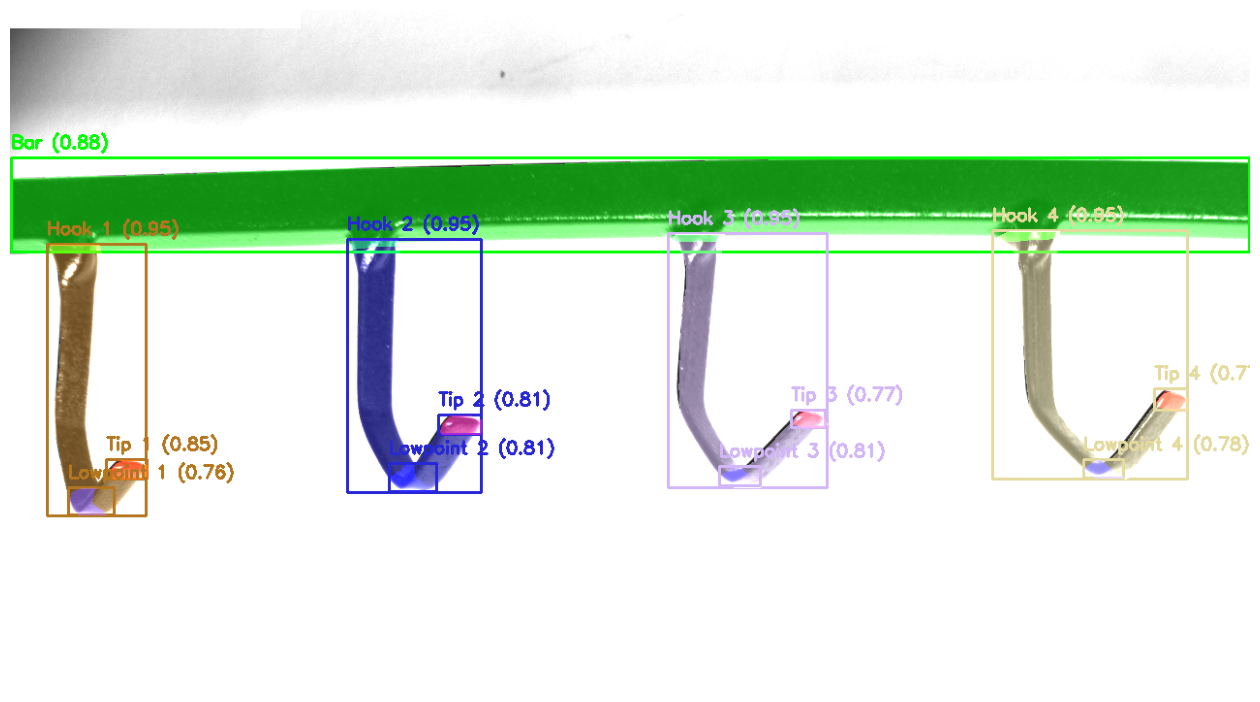

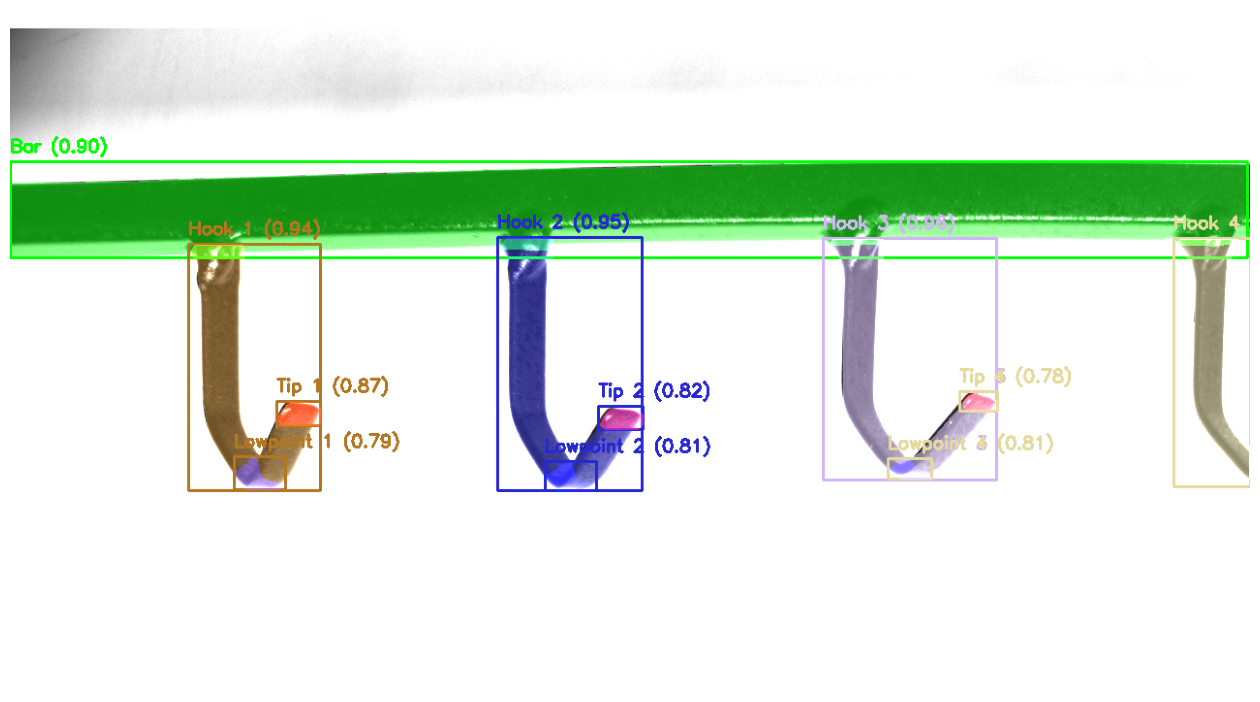

In [7]:
inp1_bar_dict, inp1_hooks_dict = yolov8_postprocessing.postprocess(results=out1, input=inp1, plot_result=True)
inp2_bar_dict, inp2_hooks_dict = yolov8_postprocessing.postprocess(results=out2, input=inp2, plot_result=True)

In [8]:
hook_inp1 = inp1_hooks_dict['hook_4']
hook_inp2 = inp2_hooks_dict['hook_1']

***
**Berechnung der Punkte über BBoxes**

In [9]:
def calc_midpoint_of_box(box):
    x1, y1, x2, y2 = box
    return [(x1+x2)/2, (y1+y2)/2]

In [10]:
hook_inp1['uv_hook'] = calc_midpoint_of_box(hook_inp1['hook_box'])
hook_inp1['uv_tip'] = calc_midpoint_of_box(hook_inp1['tip_box'])
hook_inp1['uv_lowpoint'] = calc_midpoint_of_box(hook_inp1['lowpoint_box'])

hook_inp2['uv_hook'] = calc_midpoint_of_box(hook_inp2['hook_box'])
hook_inp2['uv_tip'] = calc_midpoint_of_box(hook_inp2['tip_box'])
hook_inp2['uv_lowpoint'] = calc_midpoint_of_box(hook_inp2['lowpoint_box'])

print("Hook coordinates [px] in img 1:")
print(hook_inp1['uv_hook'])
print(hook_inp1['uv_tip'])
print(hook_inp1['uv_lowpoint'])

print("\nHook coordinates [px] in img 2:")
print(hook_inp2['uv_hook'])
print(hook_inp2['uv_tip'])
print(hook_inp2['uv_lowpoint'])

Hook coordinates [px] in img 1:
[1114.919921875, 356.73419189453125]
[1198.3446044921875, 402.6204528808594]
[1129.451171875, 474.232666015625]

Hook coordinates [px] in img 2:
[252.47869873046875, 369.46820068359375]
[298.2940673828125, 416.9868469238281]
[257.8360595703125, 478.7047424316406]


***
**Berechnung der Punkte über Momente der Segmentierung**

In [11]:
def calc_midpoint_with_moments(mask):
    M00 = np.sum(mask)  # Fläche der 1er-Pixel
    M10 = np.sum(np.arange(mask.shape[1]) * np.sum(mask, axis=0))  # Gewichtete Spaltensumme
    M01 = np.sum(np.arange(mask.shape[0]) * np.sum(mask, axis=1))  # Gewichtete Zeilensumme
    return [M10/M00, M01/M00]

In [12]:
hook_inp1['uv_hook'] = calc_midpoint_with_moments(hook_inp1['hook_mask'])
hook_inp1['uv_tip'] = calc_midpoint_with_moments(hook_inp1['tip_mask'])
hook_inp1['uv_lowpoint'] = calc_midpoint_with_moments(hook_inp1['lowpoint_mask'])

hook_inp2['uv_hook'] = calc_midpoint_with_moments(hook_inp2['hook_mask'])
hook_inp2['uv_tip'] = calc_midpoint_with_moments(hook_inp2['tip_mask'])
hook_inp2['uv_lowpoint'] = calc_midpoint_with_moments(hook_inp2['lowpoint_mask'])

print("Hook coordinates [px] in img 1:")
print(hook_inp1['uv_hook'])
print(hook_inp1['uv_tip'])
print(hook_inp1['uv_lowpoint'])

print("\nHook coordinates [px] in img 2:")
print(hook_inp2['uv_hook'])
print(hook_inp2['uv_tip'])
print(hook_inp2['uv_lowpoint'])

Hook coordinates [px] in img 1:
[1095.9148448374683, 368.4301154507492]
[1200.020484171322, 404.0223463687151]
[1126.5282608695652, 475.75652173913045]

Hook coordinates [px] in img 2:
[238.77281835141298, 382.2101844814482]
[299.2122448979592, 417.80204081632655]
[253.15843857634903, 482.82778415614234]


***
**Projektionsmatrix (Intrinsik, Extrinsik)**

In [13]:
f_x = 0.006/3.45e-6
f_y = 0.006/3.45e-6
c_x = 720/2
c_y = 1280/2

intrinsics = [[f_x, 0, c_x], 
              [0, f_y, c_y], 
              [0, 0, 1]]

In [14]:
def calc_extrinsics(angle_x = 0, angle_y = 0, angle_z = 0, t_x = 0, t_y = 0, t_z = 0):
    t = np.array([[t_x, t_y, t_z]])

    R_x = np.array([[1, 0, 0],
           [0, np.cos(angle_x), -np.sin(angle_x)],
           [0, np.sin(angle_x), np.cos(angle_x)]])

    R_y = np.array([[np.cos(angle_y), 0, np.sin(angle_y)],
           [0, 1, 0],
           [-np.sin(angle_y), 0, np.cos(angle_y)]])

    R_z = np.array([[np.cos(angle_z), -np.sin(angle_z), 0],
           [np.sin(angle_z), np.cos(angle_z), 0],
           [0, 0, 1]])

    R = R_x @ (R_y @ R_z)
    return np.hstack((R, t.T))

In [15]:
def calc_projection_matrix(intrinsics, extrinsics):
    return intrinsics @ extrinsics

In [16]:
proj1 = calc_projection_matrix(intrinsics, calc_extrinsics(0, 0, 0, 0, 0, 0))
proj2 = calc_projection_matrix(intrinsics, calc_extrinsics(0, 0, 0, 100, 0, 0))

***
**Stereo Triangulation**

In [17]:
points1 = np.array([hook_inp1['uv_hook'],
                    hook_inp1['uv_tip'],
                    hook_inp1['uv_lowpoint']], dtype=np.float64).T

points2 = np.array([hook_inp2['uv_hook'],
                    hook_inp2['uv_tip'],
                    hook_inp2['uv_lowpoint']], dtype=np.float64).T

In [18]:
points4D_hom = cv2.triangulatePoints(proj1, proj2, points1, points2)
points3D = points4D_hom[:3] / points4D_hom[3]

In [19]:
hook_xyz = points3D[:, 0]
tip_xyz = points3D[:, 1]
lowpoint_xyz = points3D[:, 2]

print("Coordinates of hook: ", hook_xyz)
print("Coordinates of tip: ", tip_xyz)
print("Coordinates of lowpoint: ", lowpoint_xyz)

Coordinates of hook:  [    -85.857      30.879     -202.89]
Coordinates of tip:  [    -93.252      25.431     -193.06]
Coordinates of lowpoint:  [    -87.767      18.401     -199.13]


In [20]:
for i in range(points3D.shape[1]):
    point = points3D[:, i]
    print(f"3D Point {i + 1}: {point}")

3D Point 1: [    -85.857      30.879     -202.89]
3D Point 2: [    -93.252      25.431     -193.06]
3D Point 3: [    -87.767      18.401     -199.13]


***
***
alt

In [190]:
baseline = 0.02        # in m

c_x = 0
c_y = 0

s_mm_per_px = 3.45e-6
f = 0.008 / s_mm_per_px
print("Focal length in px: ", f)

intrinsics = [[f, 0, c_x], [0, f, c_y], [0, 0, 1]]

Focal length in px:  2318.840579710145


In [191]:
def triangulate(p1, p2, baseline, intrinsics):
    d = p1[0] - p2[0]
    return baseline * intrinsics[0][0] / d

def calc_real_point(p_in_px, depth, intrinsics):
    return depth * (np.linalg.inv(intrinsics) @ [p_in_px[0], p_in_px[1], 1])

In [192]:
z_hook = triangulate(hook_inp1['uv_hook'], hook_inp2['uv_hook'], baseline=baseline, intrinsics=intrinsics)
z_tip = triangulate(hook_inp1['uv_tip'], hook_inp2['uv_tip'], baseline=baseline, intrinsics=intrinsics)
z_lowpoint = triangulate(hook_inp1['uv_lowpoint'], hook_inp2['uv_lowpoint'], baseline=baseline, intrinsics=intrinsics)

print("Depth z of hook: ", z_hook)
print("Depth z of tip: ", z_tip)
print("Depth z of lowpoint: ", z_lowpoint)

Depth z of hook:  0.23917258860464927
Depth z of tip:  0.2529306885642985
Depth z of lowpoint:  0.2654819268320228


In [193]:
xyz_hook = calc_real_point(p_in_px=hook_inp1['uv_hook'], depth=z_hook, intrinsics=intrinsics)
xyz_tip = calc_real_point(p_in_px=hook_inp1['uv_tip'], depth=z_tip, intrinsics=intrinsics)
xyz_lowpoint = calc_real_point(p_in_px=hook_inp1['uv_lowpoint'], depth=z_lowpoint, intrinsics=intrinsics)

print("Real coordinates of hook [m]: ", xyz_hook)
print("Real coordinates of tip [m]: ", xyz_tip)
print("Real coordinates of lowpoint [m]: ", xyz_lowpoint)

Real coordinates of hook [m]:  [   0.084992    0.043555     0.23917]
Real coordinates of tip [m]:  [   0.083069    0.039563     0.25293]
Real coordinates of lowpoint [m]:  [   0.086304    0.055149     0.26548]
